This notebook documents part 2 of the complementarity of image and demographic information: the ability of latent space extracted from Autoencoders to predict mode choice and trip generation.

In [2]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pickle as pkl
import numpy as np

import itertools
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm


from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo
from M1_util_train_test import load_model, test
import linear_reg
import mnl
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir

plt.rcParams.update({"font.size":12})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
data_version = '1571'

model_type = 'SAE'
model_code = 'M1_A1'
sampling = 's'

zoomlevel = 'zoom15'
output_dim = 3
model_run_date = '22021407'

variable_names = ['active','auto','mas','pt', 'trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']


# Load Model Embeddings

In [46]:
with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

In [47]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

# Load Trip Behavior

In [48]:
file = "origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, data_version)

train_test_index = df_pivot['train_test'].astype(bool).to_numpy()
# train_test_index = np.random.rand(len(df_pivot)) < 0.2

y = df_pivot[variable_names].to_numpy()
y_train = y[~train_test_index,:4]
y_test = y[train_test_index,:4]

In [49]:
x_train = aggregate_embeddings[~train_test_index, :]
x_test = aggregate_embeddings[train_test_index, :]

In [50]:
auto_train = y[~train_test_index,1]
auto_test = y[train_test_index,1]

pt_train = y[~train_test_index,3]
pt_test = y[train_test_index,3]

active_train = y[~train_test_index,0]
active_test = y[train_test_index,0]

trpgen_train = y[~train_test_index,-1]
trpgen_test = y[train_test_index,-1]


# 1. Linear Regression


### 1.1 Auto Share

In [51]:
# Linear Regression without Regularization
lr = linear_model.LinearRegression()
lr.fit(x_train, auto_train)
# with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#     f.write("%s,%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], -1, 
#         lr.score(x_train, auto_train), lr.score(x_test, auto_test), 'lr', zoomlevel,
#         np.sum(lr.coef_ != 0), len(lr.coef_)))
print("Train R2: %.4f \t Test R2: %.4f" % (lr.score(x_train, auto_train), lr.score(x_test, auto_test)))

Train R2: 1.0000 	 Test R2: 0.5620


In [52]:
# Lasso
for a in (1e-4)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, auto_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, auto_train), 
                                                                                  lasso.score(x_test, auto_test), 
                                                                                  np.sum(lasso.coef_ != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 0.00e+00 Train R2: 1.0000 	 Test R: 0.3306 	 Nonzero coef: 18432


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.667e-01, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-05 Train R2: 0.9997 	 Test R: 0.4540 	 Nonzero coef: 2300


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.408e+00, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-04 Train R2: 0.9742 	 Test R: 0.5207 	 Nonzero coef: 1127


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.287e-01, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 2.00e-04 Train R2: 0.9209 	 Test R: 0.6188 	 Nonzero coef: 820


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.154e+00, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 3.00e-04 Train R2: 0.8626 	 Test R: 0.6519 	 Nonzero coef: 580


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.222e+00, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 4.00e-04 Train R2: 0.8121 	 Test R: 0.6687 	 Nonzero coef: 428


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.450e-01, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 5.00e-04 Train R2: 0.7699 	 Test R: 0.6661 	 Nonzero coef: 327


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.813e-01, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 6.00e-04 Train R2: 0.7382 	 Test R: 0.6590 	 Nonzero coef: 253


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.827e-01, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 7.00e-04 Train R2: 0.7129 	 Test R: 0.6649 	 Nonzero coef: 190


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.792e-02, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 8.00e-04 Train R2: 0.6957 	 Test R: 0.6643 	 Nonzero coef: 148


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.476e-02, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-03 Train R2: 0.6749 	 Test R: 0.6634 	 Nonzero coef: 104
Parameter: 2.00e-03 Train R2: 0.6296 	 Test R: 0.6685 	 Nonzero coef: 60
Parameter: 5.00e-03 Train R2: 0.5789 	 Test R: 0.6382 	 Nonzero coef: 23


In [11]:
# Ridge

for a in (1e+1)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, auto_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, auto_train), 
                                                              ridge.score(x_test, auto_test)))

/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.54536e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Parameter: 0.00e+00 Train R2: 0.9993 	 Test R: -0.2764
Parameter: 1.00e+00 Train R2: 0.8736 	 Test R: 0.6238
Parameter: 1.00e+01 Train R2: 0.7485 	 Test R: 0.7038
Parameter: 2.00e+01 Train R2: 0.7180 	 Test R: 0.7106
Parameter: 3.00e+01 Train R2: 0.7022 	 Test R: 0.7116
Parameter: 4.00e+01 Train R2: 0.6919 	 Test R: 0.7110
Parameter: 5.00e+01 Train R2: 0.6843 	 Test R: 0.7100
Parameter: 6.00e+01 Train R2: 0.6783 	 Test R: 0.7087
Parameter: 7.00e+01 Train R2: 0.6735 	 Test R: 0.7074
Parameter: 8.00e+01 Train R2: 0.6694 	 Test R: 0.7061
Parameter: 1.00e+02 Train R2: 0.6627 	 Test R: 0.7035
Parameter: 2.00e+02 Train R2: 0.6436 	 Test R: 0.6933
Parameter: 5.00e+02 Train R2: 0.6201 	 Test R: 0.6750


### 1.2 PT

In [15]:
# Lasso
for a in (5e-5)*np.array([0,0.1,1,2,3,4,5,6,7,8,9,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, pt_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, pt_train), 
                                                                                  lasso.score(x_test, pt_test), 
                                                                                  np.sum(lasso.coef_ != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.810e-02, tolerance: 1.373e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instea

Parameter: 0.00e+00 Train R2: 0.9857 	 Test R: -0.7245 	 Nonzero coef: 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.517e-01, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 5.00e-06 Train R2: 0.9622 	 Test R: -0.0070 	 Nonzero coef: 1540


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.868e-01, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 5.00e-05 Train R2: 0.7307 	 Test R: 0.4894 	 Nonzero coef: 400


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.657e-01, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-04 Train R2: 0.6312 	 Test R: 0.5353 	 Nonzero coef: 186


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.276e-01, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.50e-04 Train R2: 0.5889 	 Test R: 0.5259 	 Nonzero coef: 107


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.005e-02, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 2.00e-04 Train R2: 0.5648 	 Test R: 0.5188 	 Nonzero coef: 78


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e-03, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 2.50e-04 Train R2: 0.5503 	 Test R: 0.5163 	 Nonzero coef: 63


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.091e-03, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 3.00e-04 Train R2: 0.5390 	 Test R: 0.5158 	 Nonzero coef: 53
Parameter: 3.50e-04 Train R2: 0.5297 	 Test R: 0.5118 	 Nonzero coef: 49
Parameter: 4.00e-04 Train R2: 0.5209 	 Test R: 0.5058 	 Nonzero coef: 41
Parameter: 4.50e-04 Train R2: 0.5151 	 Test R: 0.5012 	 Nonzero coef: 39
Parameter: 5.00e-04 Train R2: 0.5115 	 Test R: 0.4995 	 Nonzero coef: 34
Parameter: 1.00e-03 Train R2: 0.4870 	 Test R: 0.4629 	 Nonzero coef: 23
Parameter: 2.50e-03 Train R2: 0.4446 	 Test R: 0.3885 	 Nonzero coef: 12


In [22]:
# Ridge

# for a in (1e+1)*np.array([0,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,10,20,50]):
for a in (5e+0) * np.array([0, 4.5,4.6,4.7,4.8,4.9, 5, 5.1,5.2,5.3,5.4,5.5]):
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, pt_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, pt_train), 
                                                              ridge.score(x_test, pt_test)))

/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.54536e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Parameter: 0.00e+00 Train R2: 1.0000 	 Test R: -0.6301
Parameter: 2.25e+01 Train R2: 0.6198 	 Test R: 0.5394
Parameter: 2.30e+01 Train R2: 0.6186 	 Test R: 0.5394
Parameter: 2.35e+01 Train R2: 0.6175 	 Test R: 0.5393
Parameter: 2.40e+01 Train R2: 0.6164 	 Test R: 0.5393
Parameter: 2.45e+01 Train R2: 0.6153 	 Test R: 0.5393
Parameter: 2.50e+01 Train R2: 0.6142 	 Test R: 0.5392
Parameter: 2.55e+01 Train R2: 0.6132 	 Test R: 0.5392
Parameter: 2.60e+01 Train R2: 0.6122 	 Test R: 0.5391
Parameter: 2.65e+01 Train R2: 0.6112 	 Test R: 0.5391
Parameter: 2.70e+01 Train R2: 0.6102 	 Test R: 0.5390
Parameter: 2.75e+01 Train R2: 0.6093 	 Test R: 0.5390


### 1.3 Active

In [24]:
for a in (1e-3)*np.array([0,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, active_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, active_train), 
                                                                                  lasso.score(x_test, active_test), 
                                                                                  np.sum(lasso.coef_ != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.057e-01, tolerance: 3.791e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

Parameter: 0.00e+00 Train R2: 0.9839 	 Test R: -0.6109 	 Nonzero coef: 2048
Parameter: 5.00e-04 Train R2: 0.5494 	 Test R: 0.5421 	 Nonzero coef: 62
Parameter: 6.00e-04 Train R2: 0.5398 	 Test R: 0.5463 	 Nonzero coef: 48
Parameter: 7.00e-04 Train R2: 0.5332 	 Test R: 0.5476 	 Nonzero coef: 43
Parameter: 8.00e-04 Train R2: 0.5279 	 Test R: 0.5502 	 Nonzero coef: 38
Parameter: 9.00e-04 Train R2: 0.5237 	 Test R: 0.5535 	 Nonzero coef: 32
Parameter: 1.00e-03 Train R2: 0.5208 	 Test R: 0.5544 	 Nonzero coef: 33
Parameter: 2.00e-03 Train R2: 0.4938 	 Test R: 0.5418 	 Nonzero coef: 21
Parameter: 3.00e-03 Train R2: 0.4766 	 Test R: 0.5251 	 Nonzero coef: 18
Parameter: 4.00e-03 Train R2: 0.4596 	 Test R: 0.5077 	 Nonzero coef: 14
Parameter: 5.00e-03 Train R2: 0.4435 	 Test R: 0.4902 	 Nonzero coef: 14
Parameter: 1.00e-02 Train R2: 0.3692 	 Test R: 0.4247 	 Nonzero coef: 6
Parameter: 2.00e-02 Train R2: 0.2892 	 Test R: 0.3389 	 Nonzero coef: 2
Parameter: 5.00e-02 Train R2: -0.0000 	 Test R: -0

In [27]:
# Ridge

for a in (1.5e+1)*np.array([0,0.1,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,10,20,50]):
# for a in (1e+1)*np.array([0,1, 1.5, 2, 1.5, 3]):
    
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, active_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, active_train), 
                                                              ridge.score(x_test, active_test)))

/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.54536e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Parameter: 0.00e+00 Train R2: 0.9939 	 Test R: -0.5831
Parameter: 1.50e+00 Train R2: 0.8185 	 Test R: 0.4949
Parameter: 7.50e+00 Train R2: 0.7015 	 Test R: 0.5408
Parameter: 9.00e+00 Train R2: 0.6893 	 Test R: 0.5428
Parameter: 1.05e+01 Train R2: 0.6793 	 Test R: 0.5442
Parameter: 1.20e+01 Train R2: 0.6708 	 Test R: 0.5452
Parameter: 1.35e+01 Train R2: 0.6635 	 Test R: 0.5459
Parameter: 1.50e+01 Train R2: 0.6571 	 Test R: 0.5465
Parameter: 3.00e+01 Train R2: 0.6189 	 Test R: 0.5479
Parameter: 4.50e+01 Train R2: 0.5994 	 Test R: 0.5478
Parameter: 6.00e+01 Train R2: 0.5869 	 Test R: 0.5474
Parameter: 7.50e+01 Train R2: 0.5780 	 Test R: 0.5471
Parameter: 1.50e+02 Train R2: 0.5534 	 Test R: 0.5461
Parameter: 3.00e+02 Train R2: 0.5327 	 Test R: 0.5452
Parameter: 7.50e+02 Train R2: 0.5075 	 Test R: 0.5430


### 1.4 Trip Generation

In [38]:
for a in (1e-2)*np.array([0,0.1,6,7,8,10,11,12,13,14,15,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, trpgen_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, trpgen_train), 
                                                                                  lasso.score(x_test, trpgen_test), 
                                                                                  np.sum(lasso.coef_ != 0)))
#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e+03, tolerance: 3.630e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

Parameter: 0.00e+00 Train R2: 0.9876 	 Test R: -2.5644 	 Nonzero coef: 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e+04, tolerance: 3.630e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-03 Train R2: 0.9552 	 Test R: -1.1065 	 Nonzero coef: 1481
Parameter: 6.00e-02 Train R2: 0.3600 	 Test R: 0.1904 	 Nonzero coef: 64
Parameter: 7.00e-02 Train R2: 0.3392 	 Test R: 0.2006 	 Nonzero coef: 56
Parameter: 8.00e-02 Train R2: 0.3210 	 Test R: 0.2057 	 Nonzero coef: 49
Parameter: 1.00e-01 Train R2: 0.2968 	 Test R: 0.2061 	 Nonzero coef: 34
Parameter: 1.10e-01 Train R2: 0.2901 	 Test R: 0.2051 	 Nonzero coef: 32
Parameter: 1.20e-01 Train R2: 0.2845 	 Test R: 0.2024 	 Nonzero coef: 29
Parameter: 1.30e-01 Train R2: 0.2799 	 Test R: 0.2015 	 Nonzero coef: 26
Parameter: 1.40e-01 Train R2: 0.2752 	 Test R: 0.2003 	 Nonzero coef: 22
Parameter: 1.50e-01 Train R2: 0.2707 	 Test R: 0.1989 	 Nonzero coef: 23
Parameter: 2.00e-01 Train R2: 0.2482 	 Test R: 0.1862 	 Nonzero coef: 17
Parameter: 5.00e-01 Train R2: 0.1208 	 Test R: 0.0963 	 Nonzero coef: 9


In [40]:
# Ridge

for a in (1e+1)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, trpgen_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, trpgen_train), 
                                                              ridge.score(x_test, trpgen_test)))

/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.47584e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Parameter: 0.00e+00 Train R2: 1.0000 	 Test R: -2.4222
Parameter: 1.00e+00 Train R2: 0.8127 	 Test R: -0.3083
Parameter: 1.00e+01 Train R2: 0.5850 	 Test R: 0.1181
Parameter: 2.00e+01 Train R2: 0.5189 	 Test R: 0.1722
Parameter: 3.00e+01 Train R2: 0.4820 	 Test R: 0.1911
Parameter: 4.00e+01 Train R2: 0.4566 	 Test R: 0.1997
Parameter: 5.00e+01 Train R2: 0.4373 	 Test R: 0.2039
Parameter: 6.00e+01 Train R2: 0.4219 	 Test R: 0.2059
Parameter: 7.00e+01 Train R2: 0.4091 	 Test R: 0.2068
Parameter: 8.00e+01 Train R2: 0.3982 	 Test R: 0.2069
Parameter: 1.00e+02 Train R2: 0.3804 	 Test R: 0.2063
Parameter: 2.00e+02 Train R2: 0.3295 	 Test R: 0.1990
Parameter: 5.00e+02 Train R2: 0.2723 	 Test R: 0.1859


# 2. Linear Regression (PyTorch)

In [24]:
def pytorch_lr(w1_list, lr_list, x1, x2, y1, y2):
    
    mseloss = nn.MSELoss(reduction='sum')
    
    trainset = SurveyDataset(torch.tensor(x1,  dtype=torch.float), torch.tensor(y1, dtype=torch.float))
    trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=True)

    testset = SurveyDataset(torch.tensor(x2, dtype=torch.float), torch.tensor(y2, dtype=torch.float))
    testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

    # decay rates for embedding
#     w1_list = [0]
    # decay rates for demo (There is no demo in this case)
    w2_list = [0]
    # lr_list = [0.005,0.01, 0.02]
#     lr_list = [0.002]

    dim_demo = 0
    dim_embed = x1.shape[1]

    for lr in lr_list:

        for w1, w2 in itertools.product(w1_list, w2_list):

            # model setup
            model = linear_reg.LR(dim_embed=dim_embed, dim_demo=dim_demo)

#             print(model)
            embed_params = []
            demo_params = []
            other_params = []
            for name, m in model.named_parameters():
        #             print(name)
                if 'embed' in name:
                    embed_params.append(m)
                elif 'demo' in name:
                    demo_params.append(m)
                else:
                    other_params.append(m)

#             optimizer = torch.optim.Adam([{'params':demo_params,'lr':lr}])
            optimizer = torch.optim.Adam([{'params':embed_params,'weight_decay':w1,'lr':lr},
                                          {'params':demo_params,'weight_decay':w2, 'lr':lr},
                                          {'params':other_params,'weight_decay':0, 'lr':lr}])
#             optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#             print(optimizer)
#             print(demo_params)
            
            # model training
            ref1 = 0
            ref2 = 0

            for epoch in range(1000):

                mse_ = 0

                for batch, (x_batch, y_batch) in enumerate(trainloader):
                    # Compute prediction and loss
                    pred = model(x_batch, None)
                    pred = F.relu(pred).squeeze()

                    mse = mseloss(pred, y_batch)
                    mse_ += mse.item()

                    # Backpropagation
                    optimizer.zero_grad()
                    mse.backward()
                    optimizer.step()

                train_r = r2_score(y_batch.numpy(), pred.detach().numpy())
                train_mse = mse_/len(trainset)

                if epoch % 20 == 0:
                    print(f"[epoch: {epoch:>3d}] Train MSE : {train_mse:.4f} R2 score: {train_r:.3f} ")
                loss_ = train_mse

                if epoch % 5 == 0:
                    if epoch >=40:
                        if (np.abs(loss_ - ref1)/ref1<0.0005) & (np.abs(loss_ - ref2)/ref2<0.0005):
                            print("Early stopping at epoch", epoch)
                            print(ref2, ref1, loss_)
                            break
                        if (ref1 < loss_) & (ref1 < ref2):
                            print("Diverging. stop.")
                            break
                        if loss_ < best:
                            best = loss_
                            best_epoch = epoch
                    else:
                        best = loss_
                        best_epoch = epoch

                    ref2 = ref1
                    ref1 = loss_

                if epoch % 20 == 0:

                    mse_ = 0 

                    for batch, (x_batch, y_batch) in enumerate(testloader):
                        pred = model(x_batch, None)
                        pred = F.relu(pred).squeeze()

                        mse = mseloss(pred, y_batch)
                        mse_ += mse.item()
                        
#                     print(len(testset))

                    test_mse = mse_/len(testset)
                    test_r = r2_score(y_batch.numpy(),pred.detach().numpy())

                    print(f"[epoch: {epoch:>3d}] Test MSE {test_mse:.4f} R2 score: {test_r:.3f} ")
    return model

    #         with open(out_dir+model_code+"_regression_trpgen.csv", "a") as f:
    #             f.write("%s,%s,%s,%s,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
    #                 (model_run_date, model_type, zoomlevel, "LR", lr, w1, 
    #                   train_rmse, train_r, test_rmse, test_r))

In [56]:
model = pytorch_lr(w1_list=[0.0003], lr_list=[0.001], x1=x_train, x2=x_test, y1=auto_train, y2=auto_test)


[epoch:   0] Train MSE : 0.6495 R2 score: -10.921 
[epoch:   0] Test MSE 0.6646 R2 score: -12.113 
[epoch:  20] Train MSE : 0.5560 R2 score: -9.205 
[epoch:  20] Test MSE 0.5561 R2 score: -9.973 
[epoch:  40] Train MSE : 0.3196 R2 score: -4.867 
[epoch:  40] Test MSE 0.3185 R2 score: -5.284 
[epoch:  60] Train MSE : 0.1762 R2 score: -2.234 
[epoch:  60] Test MSE 0.1752 R2 score: -2.457 
[epoch:  80] Train MSE : 0.1045 R2 score: -0.918 
[epoch:  80] Test MSE 0.1029 R2 score: -1.031 
[epoch: 100] Train MSE : 0.0732 R2 score: -0.344 
[epoch: 100] Test MSE 0.0708 R2 score: -0.396 
[epoch: 120] Train MSE : 0.0615 R2 score: -0.128 
[epoch: 120] Test MSE 0.0581 R2 score: -0.146 
[epoch: 140] Train MSE : 0.0576 R2 score: -0.057 
[epoch: 140] Test MSE 0.0536 R2 score: -0.057 
[epoch: 160] Train MSE : 0.0564 R2 score: -0.036 
[epoch: 160] Test MSE 0.0520 R2 score: -0.026 
[epoch: 180] Train MSE : 0.0560 R2 score: -0.028 
[epoch: 180] Test MSE 0.0514 R2 score: -0.013 
[epoch: 200] Train MSE : 0.0

In [32]:
pytorch_lr(w1_list=[0.00001], lr_list=[0.5], x1=x_train, x2=x_test, y1=pt_train, y2=pt_test)


[epoch:   0] Train MSE : 0.0146 R2 score: -0.502 
[epoch:   0] Test MSE 0.0839 R2 score: -7.997 
[epoch:  20] Train MSE : 0.0146 R2 score: -0.502 
[epoch:  20] Test MSE 0.0141 R2 score: -0.513 
[epoch:  40] Train MSE : 0.0146 R2 score: -0.502 
Early stopping at epoch 40
0.01458367667407261 0.014583678022975463 0.014583679371878315


LR(
  (embed): Linear(in_features=2048, out_features=1, bias=True)
)

In [71]:
torch.save(model.state_dict(), out_dir+"image_weights.pt")

# 2. MNL for Mode Share

In [53]:
# dataloader and model definition

trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)

testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

kldivloss = nn.KLDivLoss(reduction='sum')
mseloss = nn.MSELoss(reduction='none')

In [54]:
sst_train = np.sum(np.power(y_train - np.mean(y_train, axis=0), 2), axis=0)
sst_test = np.sum(np.power(y_test - np.mean(y_test, axis=0), 2), axis=0)

In [67]:
def mnl_torch(lr_list, wd_list):
    
    for (lr, wd) in itertools.product(lr_list, wd_list):
        
        print(f"[lr: {lr:.4f}, wd: {wd:3.2e}]")

        # model setup
        model = mnl.MNL(n_alts=4, n_features=x_train.shape[-1])
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

#         print(optimizer)
        # model training

        ref1 = 0
        ref2 = 0

        for epoch in range(5000):

            kl_ = 0
            mse_ = 0
            mse1_ = 0
            mse2_ = 0
            mse3_ = 0
            mse4_ = 0

            for batch, (x_batch, y_batch) in enumerate(trainloader):
                
                # Compute prediction and loss
                util = model(x_batch)
                probs = torch.log(nn.functional.softmax(util, dim=1))
                kl = kldivloss(probs, y_batch)
        #         kl = kldivloss(torch.log(util), y_batch)
                kl_ += kl.item()

                mse = mseloss(torch.exp(probs), y_batch)
        #         mse = mseloss(util, y_batch)
                mse_ += mse.sum().item()
                mse1_ += mse[:,0].sum().item()
                mse2_ += mse[:,1].sum().item()
                mse3_ += mse[:,2].sum().item()
                mse4_ += mse[:,3].sum().item()
                mse = mse.sum()

                # Backpropagation
                optimizer.zero_grad()
                kl.backward()
                optimizer.step()

            train_kl = kl_/len(trainset)
            train_mse = np.sqrt(mse_/len(trainset))
            train_mse1 = np.sqrt(mse1_/len(trainset))
            train_mse2 = np.sqrt(mse2_/len(trainset))
            train_mse3 = np.sqrt(mse3_/len(trainset))
            train_mse4 = np.sqrt(mse4_/len(trainset))

            train_r1 = 1-mse1_/sst_train[0]
            train_r2 = 1-mse2_/sst_train[1]
            train_r3 = 1-mse3_/sst_train[2]
            train_r4 = 1-mse4_/sst_train[3]

            loss_ = train_kl

            if epoch % 5 == 0:

                kl_ = 0
                mse_ = 0 
                mse1_ = 0
                mse2_ = 0
                mse3_ = 0
                mse4_ = 0

                for batch, (x_batch, y_batch) in enumerate(testloader):
                    
                    util = model(x_batch)
                    probs = torch.log(nn.functional.softmax(util,dim=1))
                    kl = kldivloss(probs, y_batch)
            #         kl = kldivloss(torch.log(util), y_batch)
                    kl_ += kl.item()

                    mse = mseloss(torch.exp(probs), y_batch)
            #         mse = mseloss(util, y_batch)
                    mse_ += mse.sum().item()
                    mse1_ += mse[:,0].sum().item()
                    mse2_ += mse[:,1].sum().item()
                    mse3_ += mse[:,2].sum().item()
                    mse4_ += mse[:,3].sum().item()

                test_kl = kl_/len(testset)
                test_mse = np.sqrt(mse_/len(testset))
                test_mse1 = np.sqrt(mse1_/len(testset))
                test_mse2 = np.sqrt(mse2_/len(testset))
                test_mse3 = np.sqrt(mse3_/len(testset))
                test_mse4 = np.sqrt(mse4_/len(testset))

                r1 = r2_score(y_batch.numpy()[:,0],torch.exp(probs).detach().numpy()[:,0])
                r2 = r2_score(y_batch.numpy()[:,1],torch.exp(probs).detach().numpy()[:,1])
                r3 = r2_score(y_batch.numpy()[:,2],torch.exp(probs).detach().numpy()[:,2])
                r4 = r2_score(y_batch.numpy()[:,3],torch.exp(probs).detach().numpy()[:,3])

                if epoch >= 40:
#                     if (np.abs(loss_ - ref1)/ref1<0.001) & (np.abs(loss_ - ref2)/ref2<0.001):
#                         print("Early stopping at epoch", epoch)
#                         break
#                     if (ref1 < loss_) & (ref1 < ref2):
#                         print("Diverging. stop.")
#                         break
                    if loss_ < best:
                        best = loss_
                        best_epoch = epoch
                        output = (train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
                                  test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
                                  train_r1, train_r2, train_r3, train_r4, r1, r2, r3, r4)
                else:
                    best = loss_
                    best_epoch = epoch
                    output = (train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
                                  test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
                                  train_r1, train_r2, train_r3, train_r4, r1, r2, r3, r4)
                ref2 = ref1
                ref1 = loss_

#             if epoch % 20 == 0:

#                 print(f"[epoch: {epoch:>3d}] Train KL loss: {train_kl:.3f} RMSE {train_mse:.3f}")
#                    # {train_mse1:.3f} {train_mse2:.3f} {train_mse3:.3f} {train_mse4:.3f}")
#                 print(f"\t\t\t\t\t\t Train R2 score: {train_r1:.3f} {train_r2:.3f} {train_r3:.3f} {train_r4:.3f} ")
#                 print(f"[epoch: {epoch:>3d}] Test KL loss: {kl_/len(testset):.3f} RMSE {np.sqrt(mse_/len(testset)):.3f}")
#                    #     {np.sqrt(mse1_/len(testset)):.3f} {np.sqrt(mse2_/len(testset)):.3f} {np.sqrt(mse3_/len(testset)):.3f} {np.sqrt(mse4_/len(testset)):.3f}")
#                 print(f"\t\t\t\t\t\t Test R2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")

#                 print(f"[epoch: {epoch:>3d}] Train KL loss: {train_kl:.3f} Train R2 score: {train_r1:.3f} {train_r2:.3f} {train_r3:.3f} {train_r4:.3f} ")
#                 print(f"[epoch: {epoch:>3d}] Test KL loss: {kl_/len(testset):.3f} Test R2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")

#         with open(out_dir+"BA_mode_choice.csv", "a") as f:
#             f.write("%s,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % 
#                     (("MNL",lr, wd)+output))

        print(f"[epoch: {best_epoch:>3d}] Train KL loss: {output[0]:.3f} Train R2 score: {output[12]:.3f} {output[13]:.3f} {output[14]:.3f} {output[15]:.3f} ")
        print(f"[epoch: {best_epoch:>3d}] Test KL loss: {output[6]:.3f} Test R2 score: {output[16]:.3f} {output[17]:.3f} {output[18]:.3f} {output[19]:.3f} ")
        print()
        
    return model

In [57]:
model = mnl_torch(lr_list=[0.0001], wd_list=[0, 1e-7, 1e-6])

[lr: 0.0001, wd: 0.00e+00]
[epoch: 4960] Train KL loss: 0.042 Train R2 score: 0.922 0.940 0.818 0.913 
[epoch: 4960] Test KL loss: 0.118 Test R2 score: 0.422 0.654 -0.208 0.436 

[lr: 0.0001, wd: 1.00e-07]
[epoch: 4995] Train KL loss: 0.043 Train R2 score: 0.926 0.938 0.761 0.910 
[epoch: 4995] Test KL loss: 0.119 Test R2 score: 0.418 0.656 -0.245 0.447 

[lr: 0.0001, wd: 1.00e-06]
[epoch: 4995] Train KL loss: 0.043 Train R2 score: 0.909 0.932 0.788 0.917 
[epoch: 4995] Test KL loss: 0.117 Test R2 score: 0.436 0.660 -0.237 0.441 



In [59]:
mnl_torch(lr_list=[0.0003], wd_list=[1e-5, 1e-4, 1e-3])

[lr: 0.0003, wd: 1.00e-05]
[epoch: 4995] Train KL loss: 0.047 Train R2 score: 0.908 0.931 0.686 0.909 
[epoch: 4995] Test KL loss: 0.117 Test R2 score: 0.441 0.653 -0.229 0.437 

[lr: 0.0003, wd: 1.00e-04]


KeyboardInterrupt: 

In [60]:
mnl_torch(lr_list=[0.0005], wd_list=[1e-2, 1e-1])

[lr: 0.0005, wd: 1.00e-02]
[epoch: 4995] Train KL loss: 0.048 Train R2 score: 0.904 0.930 0.687 0.899 
[epoch: 4995] Test KL loss: 0.116 Test R2 score: 0.447 0.659 -0.205 0.456 

[lr: 0.0005, wd: 1.00e-01]
[epoch: 4980] Train KL loss: 0.047 Train R2 score: 0.907 0.930 0.676 0.902 
[epoch: 4980] Test KL loss: 0.120 Test R2 score: 0.403 0.629 -0.270 0.440 



MNL(
  (beta): Linear(in_features=18432, out_features=4, bias=True)
)

In [61]:
mnl_torch(lr_list=[0.0005], wd_list=[1,2,3,4,5])

[lr: 0.0005, wd: 1.00e+00]
[epoch: 4995] Train KL loss: 0.049 Train R2 score: 0.907 0.927 0.658 0.887 
[epoch: 4995] Test KL loss: 0.117 Test R2 score: 0.436 0.652 -0.202 0.453 

[lr: 0.0005, wd: 2.00e+00]


KeyboardInterrupt: 

In [68]:
model = mnl_torch(lr_list=[0.0002], wd_list=[10])

[lr: 0.0002, wd: 1.00e+01]
[epoch: 4990] Train KL loss: 0.055 Train R2 score: 0.878 0.906 0.579 0.870 
[epoch: 4990] Test KL loss: 0.114 Test R2 score: 0.459 0.661 -0.188 0.483 



In [71]:
mnl_torch(lr_list=[0.0001], wd_list=[50])

[lr: 0.0001, wd: 5.00e+01]
[epoch: 4985] Train KL loss: 0.085 Train R2 score: 0.758 0.813 0.259 0.734 
[epoch: 4985] Test KL loss: 0.108 Test R2 score: 0.504 0.680 -0.128 0.542 



MNL(
  (beta): Linear(in_features=18432, out_features=4, bias=True)
)

In [72]:
mnl_torch(lr_list=[0.0001], wd_list=[75])

[lr: 0.0001, wd: 7.50e+01]
[epoch: 4995] Train KL loss: 0.093 Train R2 score: 0.721 0.784 0.198 0.696 
[epoch: 4995] Test KL loss: 0.107 Test R2 score: 0.514 0.684 -0.120 0.549 



MNL(
  (beta): Linear(in_features=18432, out_features=4, bias=True)
)

In [73]:
mnl_torch(lr_list=[0.0001], wd_list=[100])

[lr: 0.0001, wd: 1.00e+02]
[epoch: 4985] Train KL loss: 0.098 Train R2 score: 0.695 0.764 0.162 0.670 
[epoch: 4985] Test KL loss: 0.107 Test R2 score: 0.519 0.686 -0.116 0.551 



MNL(
  (beta): Linear(in_features=18432, out_features=4, bias=True)
)

In [74]:
mnl_torch(lr_list=[0.0001], wd_list=[200])

[lr: 0.0001, wd: 2.00e+02]
[epoch: 4775] Train KL loss: 0.110 Train R2 score: 0.638 0.718 0.098 0.613 
[epoch: 4775] Test KL loss: 0.108 Test R2 score: 0.524 0.681 -0.130 0.543 



MNL(
  (beta): Linear(in_features=18432, out_features=4, bias=True)
)

In [70]:
torch.save(model.state_dict(), out_dir+"ac4_sae_22021407_1e-4_25.pt")


## Substitution Curve

In [67]:
select = np.array(unique_ct)[~train_test_index].tolist().index("17_197_881800")
target = np.array(unique_ct)[~train_test_index].tolist().index("17_31_842100")

In [70]:
label = {0: "Active", 1:"Auto", 3:"Public Transit"}

In [68]:
for alpha in np.linspace(0, 1, 6):
    temp = x_train[select].copy() * (1-alpha) + x_train[target].copy() * (alpha)

    if alpha == 0:
        test_in = x_train[select].copy().reshape(1, -1)
    else:
        test_in = np.concatenate([test_in, temp.reshape(1,-1)], axis=0)

test_in = torch.tensor(test_in, dtype=torch.float32)

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


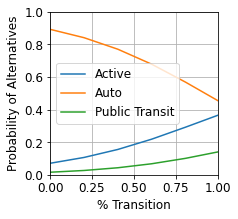

In [81]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
probs = F.softmax(model(torch.tensor(test_in))).detach().numpy()
for i in [0,1,3]:
    ax.plot(np.linspace(0,1.01,test_in.shape[0]), probs[:,i], label=label[i])
#     print(probs[:,i])
ax.set_ylabel("Probability of Alternatives")
ax.set_xlabel("% Transition")
ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid()
plt.show()